# Explore XCO2 in OCO-2 dataset

In [104]:
# to display plots in notebook
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300  # high res plots
rcParams["font.size"] = 8

import warnings
warnings.filterwarnings('ignore')

## Import packages

In [105]:
import matplotlib.pyplot as plt # plots
import cartopy.crs as ccrs      # map projections
import pandas as pd             # large arrays
import numpy as np              # large arrays and matrices
import xarray as xr             # major tool to work with NetCDF data!
# custom color map downloaded from GEOS-Chem python tutorial
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable
#type(WhGrYlRd)
import re

### Read in OCO-2 file

In [106]:
#fname = '/home/msadiq/Desktop/co2/data/satellite/OCO2_b91_10sec_GOOD_r24.nc4'
fname = './OCO2_b91_10sec_GOOD_r24.nc4'
ds = xr.open_dataset(fname, engine='netcdf4')
ds['sigma_levels']

<xarray.DataArray 'sigma_levels' (levels: 20)>
array([1.000000e-04, 5.263158e-02, 1.052632e-01, 1.578947e-01, 2.105263e-01,
       2.631579e-01, 3.157895e-01, 3.684210e-01, 4.210526e-01, 4.736842e-01,
       5.263158e-01, 5.789474e-01, 6.315789e-01, 6.842105e-01, 7.368421e-01,
       7.894737e-01, 8.421053e-01, 8.947368e-01, 9.473684e-01, 1.000000e+00],
      dtype=float32)
Dimensions without coordinates: levels
Attributes:
    units:      none
    long_name:  Retrieval Sigma Levels
    comment:    The sigma levels on which the OCO-2 retrieval is carried out....

### Read in data and use Pandas package

In [107]:
# first and last day of extraction
first_day = '2018-03-01'
last_day_p1 = '2018-04-01' # last day plus 1

In [108]:
# convert time input to match the format of sound_id
first_day_digital = re.sub("[^0-9]", "", first_day)
last_day_p1_digital = re.sub("[^0-9]", "", last_day_p1)
begin = int(first_day_digital + '000000')  # begin and end of time slice we want to look at
end = int(last_day_p1_digital + '000000')  # OCO-2 format

In [109]:
# get a slice of time window
ds_slice = ds.sel(sounding_id=slice(begin,end))

In [110]:
#dr_xco2 = ds['xco2']                     # column co2 concentration, ppm
#dr_kernel = ds['xco2_averaging_kernel']  # averaging kernel to get xco2 from [co2]
dr_psurf = ds_slice['psurf']             # surface pressure
lon_series = ds_slice['longitude']
lat_series = ds_slice['latitude']
sound_id = ds_slice['sounding_id']             # time
sigma = ds['sigma_levels']               # sigma levels

In [111]:
df = pd.DataFrame({'sound_id': sound_id, 
                        'lon': lon_series, 
                        'lat': lat_series, 
                        'psurf': dr_psurf})
df.head()

,sound_id,lon,lat,psurf
0,20180301005336,-166.029999,-33.000000,1011.929993
1,20180301005346,-166.080002,-32.779999,1014.880005
2,20180301005416,-166.570007,-30.740000,1013.760010
3,20180301005436,-166.789993,-29.809999,1012.669983
4,20180301005446,-166.919998,-29.320000,1013.510010


In [112]:
# Creat target grid
lat_res = 2   # horizontal resolution of lat and lon you would want
lon_res = 2.5
lat = np.linspace(-90, 90, 91) # grid, 91 = 180/lat_res + 1
lon = np.linspace(-180, 177.5, 144) # 144 = 360/lon_res, doesn't work sometimes

day_1 = np.array(first_day,dtype='datetime64[D]') # convert date to datetime64 format
day_end = np.array(last_day_p1,dtype='datetime64[D]') # easy to use np.arange
days = np.arange(day_1, day_end, dtype='datetime64[D]') # time dimension of output

target = xr.DataArray(data = 0, 
                      dims = ('lat', 'lon', 'time', 'levels'), 
                      coords = {'lat': lat,
                                'lon': lon,
                                'time': days,
                                'levels': sigma.values}, # newly added
                      name = 'pressure')

target = target.astype(dtype='float32')
#target

In [113]:
print(type(last_day_p1_digital))
days_range = np.arange(first_day, last_day_p1, dtype='datetime64[D]')
days_range

<class 'str'>


array(['2018-03-01', '2018-03-02', '2018-03-03', '2018-03-04',
       '2018-03-05', '2018-03-06', '2018-03-07', '2018-03-08',
       '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12',
       '2018-03-13', '2018-03-14', '2018-03-15', '2018-03-16',
       '2018-03-17', '2018-03-18', '2018-03-19', '2018-03-20',
       '2018-03-21', '2018-03-22', '2018-03-23', '2018-03-24',
       '2018-03-25', '2018-03-26', '2018-03-27', '2018-03-28',
       '2018-03-29', '2018-03-30', '2018-03-31'], dtype='datetime64[D]')

In [114]:
# map to target grid
for iday in np.arange(len(days_range)-1):
    for ilon in np.arange(len(lon)-1):
        for ilat in np.arange(len(lat)-1):
            day1=re.sub("[^0-9]", "", str(days_range[iday]))
            day2=re.sub("[^0-9]", "", str(days_range[iday+1]))
            begin = int(str(day1) + '000000')  # begin and end of time slice we want to look at
            end = int(str(day2) + '000000')  # OCO-2 format
            df_slice_time = df[df['sound_id'].between(begin, end)]
            df_slice_lat = df_slice_time[df_slice_time['lat'].between(lat[ilat],lat[ilat+1], inclusive = True)]
            df_slice_lon = df_slice_lat[df_slice_lat['lon'].between(lon[ilon],lon[ilon+1], inclusive = True)]
            if len(df_slice_lon) != 0:
                target[ilat,ilon,iday,:] = sigma.values * df_slice_lon.psurf.mean() # include deviation as well?

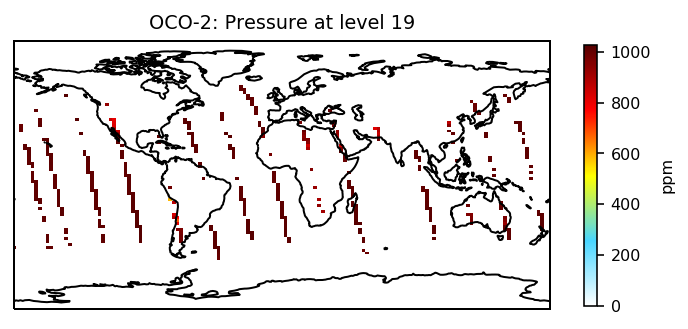

In [115]:
# plot after mapping
fig = plt.figure(figsize=[6, 6])
proj=ccrs.PlateCarree()

ax = plt.subplot(111, projection=proj)
ax.coastlines()
target.isel(time=iday, levels=19).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=WhGrYlRd, cbar_kwargs={'shrink': 0.4, 'label': 'ppm'})

ax.set_title('OCO-2: Pressure at level 19');

In [116]:
target.to_netcdf('psurf_4d_' + first_day + '_' + last_day_p1 +'.nc')